In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import warnings
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import pandas_profiling
from scipy.stats import chi2_contingency, chi2
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.ensemble import RandomForestClassifier
from feature_engine.selection import SelectBySingleFeaturePerformance
from sklearn.preprocessing import MinMaxScaler
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.model_selection import GridSearchCV
from sklearn import svm

In [2]:
data=pd.read_csv('Data\ds_salaries.csv')

### Data exploration

In [3]:
data.shape

(607, 12)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


In [5]:
data.isnull().sum()

Unnamed: 0            0
work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [6]:
data.duplicated().sum()

0

#### *Nhận xét: Dữ liệu không dup không null

In [7]:
#có 1 cột thừa
data.drop('Unnamed: 0',axis=1,inplace=True)

In [8]:
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [9]:
data.tail()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M
603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M
604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M
605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M
606,2022,MI,FT,AI Scientist,200000,USD,200000,IN,100,US,L


In [10]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
work_year,607.0,NaN,NaN,NaN,2021.405272,0.692133,2020.0,2021.0,2022.0,2022.0,2022.0
experience_level,607,4,SE,280,NaN,NaN,NaN,NaN,NaN,NaN,NaN
employment_type,607,4,FT,588,NaN,NaN,NaN,NaN,NaN,NaN,NaN
job_title,607,50,Data Scientist,143,NaN,NaN,NaN,NaN,NaN,NaN,NaN
salary,607.0,NaN,NaN,NaN,324000.062603,1544357.486636,4000.0,70000.0,115000.0,165000.0,30400000.0
salary_currency,607,17,USD,398,NaN,NaN,NaN,NaN,NaN,NaN,NaN
salary_in_usd,607.0,NaN,NaN,NaN,112297.869852,70957.259411,2859.0,62726.0,101570.0,150000.0,600000.0
employee_residence,607,57,US,332,NaN,NaN,NaN,NaN,NaN,NaN,NaN
remote_ratio,607.0,NaN,NaN,NaN,70.92257,40.70913,0.0,50.0,100.0,100.0,100.0
company_location,607,50,US,355,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
objects= [f for f in data.columns if data.dtypes[f]=='object']
print ('Non-numeric features:', objects)
i=1
for obj in objects:
    print (f'{i}.{obj}\t{len(data[obj].unique())} unique values')
    i=i+1

Non-numeric features: ['experience_level', 'employment_type', 'job_title', 'salary_currency', 'employee_residence', 'company_location', 'company_size']
1.experience_level	4 unique values
2.employment_type	4 unique values
3.job_title	50 unique values
4.salary_currency	17 unique values
5.employee_residence	57 unique values
6.company_location	50 unique values
7.company_size	3 unique values


In [12]:
numeric= [f for f in data.columns if data.dtypes[f]!='object']
print ('Numeric features:', numeric)
i=1
for num in numeric:
    print (f'{i}.{num}\t{len(data[num].unique())} unique values')
    i=i+1

Numeric features: ['work_year', 'salary', 'salary_in_usd', 'remote_ratio']
1.work_year	3 unique values
2.salary	272 unique values
3.salary_in_usd	369 unique values
4.remote_ratio	3 unique values


### Xác định thuộc tính
<dl>
<dt>Biến input: <> salary_in_usd </dt>
<dt>Biến output: salary_in_usd </dt>
<dt>Type of variable:</dt>
<dd>1. Predictor: <> salary_in_usd</dd>
<dd>2. Target: salary_in_usd</dd>
<dt>Variable category</dt>
<dd>1. Categorical variable: work_year, experience_level, employment_type, job_title, salary_currency, employee_residence, remote_ratio, company_location, company_size </dd>
<dd>2. Continuous variable: salary, salary_in_usd</dd>
</dl>

In [13]:
profile=pandas_profiling.ProfileReport(data)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
categorical_variables=['work_year', 'experience_level', 'employment_type', 'job_title', 'salary_currency', 'employee_residence', 'remote_ratio', 'company_location', 'company_size']
continuous_variables=['salary', 'salary_in_usd']

### Phân tích đơn biến

In [15]:
def phan_tich_don_bien (data, col, types):
    if types=='cont':
        print('\nThống kê cơ bản',col)
        print('_________________________________')
        print('Số lượng kiểu biến trong',col,'là', len(data[col].unique()),'\t', data[col].unique() if len(data[col].unique())<100 else '')
        print("Max =",data[col].max(),"\tMin",data[col].min())
        print("Range =",data[col].max()-data[col].min())
        print("Mean =", data[col].mean())
        print("Median =", np.median(data[col]))
        print("Mode =", data[col].mode().values)
        print('_________________________________')
        print('Variance =', round(np.var(data[col]),3))
        print('Standard deviation =', round(np.std(data[col]),3))
        print('_________________________________')
        Q1=np.quantile(data[col].dropna(),0.25)
        Q3=np.quantile(data[col].dropna(),0.75)
        IQR=Q3-Q1
        print('Tứ phân vị số Q1:',Q1,'\nTứ phân vị số Q3:',Q3)
        print('IQR:', IQR)
        n_o_upper= data[data[col]>(Q3+1.5*IQR)].shape[0]
        n_o_lower= data[data[col]<(Q1-1.5*IQR)].shape[0]
        print('Số lượng lower outliers:',n_o_lower)
        print('Số lượng upper outliers:',n_o_upper)
        print('Số lượng outlier chiếm', round((n_o_lower+n_o_upper)/data.shape[0]*100,3),'%')
        print('_________________________________')
        skew=data[col].skew()
        if skew>0:
            print('Phân phối lệch phải với giá trị skew =',skew)
        elif skew<0:
            print('Phân phối lệch trái với giá trị skew =',skew)
        else:
            print('Phân phối đối xứng với giá trị skew =',skew)
        kurt=data[col].kurtosis()
        if kurt>0:
            print('Phân phối nhọn hơn phân phối chuẩn với kurt=',kurt)
        elif kurt<0:
            print('Phân phối bầu hơn phân phối chuẩn với kurt=',kurt)
        else:
            print('Phân phối là phân phối chuẩn với kurt=',kurt)
        print('_________________________________')
        print('Visualize')
        f=plt.figure(figsize=(8,6), tight_layout=True)
        plt.subplot(211)
        plt.title('Biểu đồ distplot phân phối của '+str(col))
        sns.distplot(data[col])
        plt.subplot(212)
        plt.title('Biểu đồ boxplot phân phối của '+str(col))
        sns.boxplot(x=data[col])
        plt.show()
    elif types=='cate':
        print(f'\nDữ liệu cơ bản của {col}:')
        print('_________________________________')
        print('Có',len(data[col].unique()),'biến phân loại',col,'là:\n',data[col].unique() if len(data[col].unique())<100 else '')
        print('Bảng phân loại và tỷ trọng của các loại biến của',col)
        counts=data[col].value_counts()
        percent=data[col].value_counts(normalize=True).mul(100).round(2).astype(str)+'%'
        print(pd.DataFrame({'counts': counts,'percentage':percent}))
        f=plt.figure(figsize=(8,6),tight_layout=True)
        plt.title('Biểu đồ dữ liệu phân loại của '+str(col))
        sns.set()
        counts.plot.bar()
        plt.xticks(rotation=45)
        plt.show()

#### Phân tích đơn biến categorical


Dữ liệu cơ bản của work_year:
_________________________________
Có 3 biến phân loại work_year là:
 [2020 2021 2022]
Bảng phân loại và tỷ trọng của các loại biến của work_year
      counts percentage
2022     318     52.39%
2021     217     35.75%
2020      72     11.86%


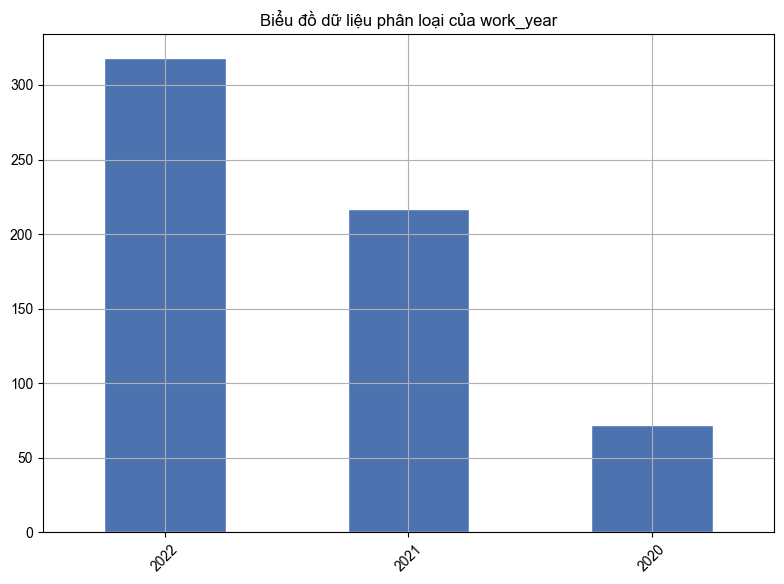


Dữ liệu cơ bản của experience_level:
_________________________________
Có 4 biến phân loại experience_level là:
 ['MI' 'SE' 'EN' 'EX']
Bảng phân loại và tỷ trọng của các loại biến của experience_level
    counts percentage
SE     280     46.13%
MI     213     35.09%
EN      88      14.5%
EX      26      4.28%


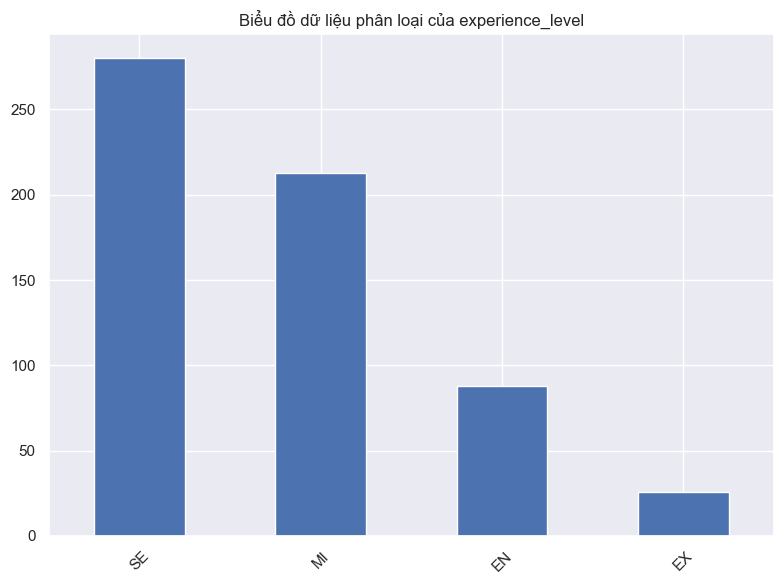


Dữ liệu cơ bản của employment_type:
_________________________________
Có 4 biến phân loại employment_type là:
 ['FT' 'CT' 'PT' 'FL']
Bảng phân loại và tỷ trọng của các loại biến của employment_type
    counts percentage
FT     588     96.87%
PT      10      1.65%
CT       5      0.82%
FL       4      0.66%


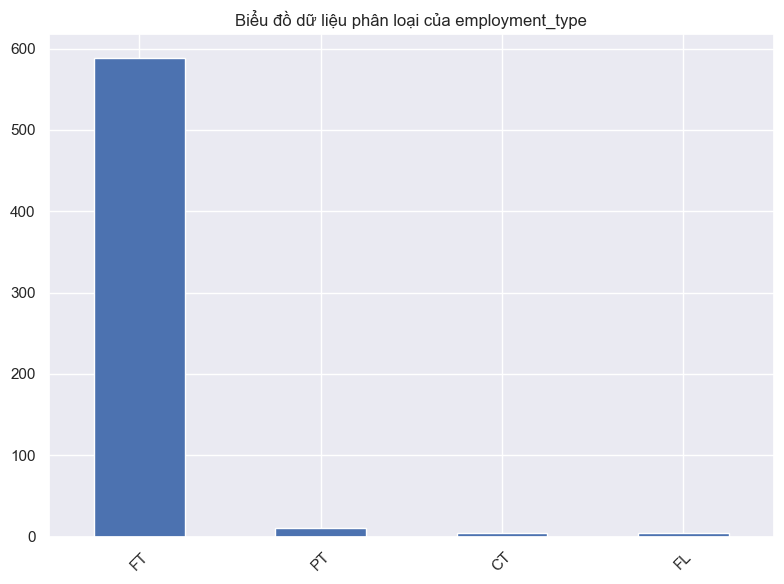


Dữ liệu cơ bản của job_title:
_________________________________
Có 50 biến phân loại job_title là:
 ['Data Scientist' 'Machine Learning Scientist' 'Big Data Engineer'
 'Product Data Analyst' 'Machine Learning Engineer' 'Data Analyst'
 'Lead Data Scientist' 'Business Data Analyst' 'Lead Data Engineer'
 'Lead Data Analyst' 'Data Engineer' 'Data Science Consultant'
 'BI Data Analyst' 'Director of Data Science' 'Research Scientist'
 'Machine Learning Manager' 'Data Engineering Manager'
 'Machine Learning Infrastructure Engineer' 'ML Engineer' 'AI Scientist'
 'Computer Vision Engineer' 'Principal Data Scientist'
 'Data Science Manager' 'Head of Data' '3D Computer Vision Researcher'
 'Data Analytics Engineer' 'Applied Data Scientist'
 'Marketing Data Analyst' 'Cloud Data Engineer' 'Financial Data Analyst'
 'Computer Vision Software Engineer' 'Director of Data Engineering'
 'Data Science Engineer' 'Principal Data Engineer'
 'Machine Learning Developer' 'Applied Machine Learning Scientist'
 '

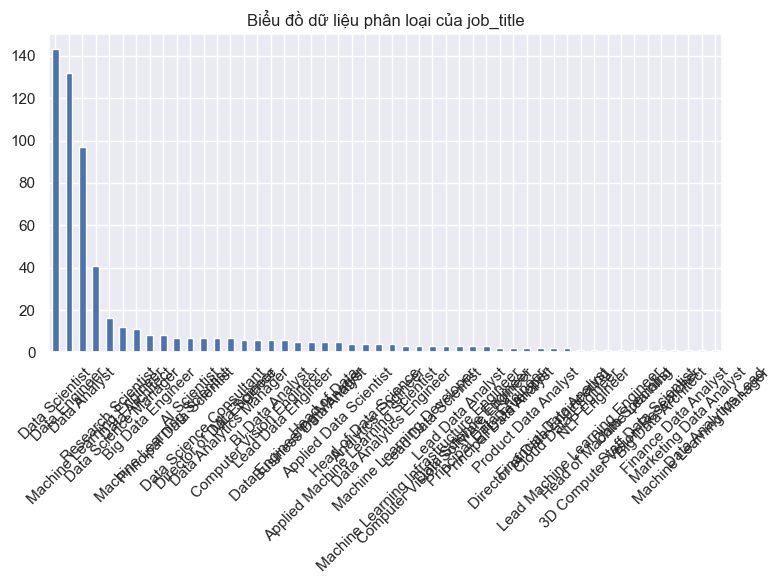


Dữ liệu cơ bản của salary_currency:
_________________________________
Có 17 biến phân loại salary_currency là:
 ['EUR' 'USD' 'GBP' 'HUF' 'INR' 'JPY' 'CNY' 'MXN' 'CAD' 'DKK' 'PLN' 'SGD'
 'CLP' 'BRL' 'TRY' 'AUD' 'CHF']
Bảng phân loại và tỷ trọng của các loại biến của salary_currency
     counts percentage
USD     398     65.57%
EUR      95     15.65%
GBP      44      7.25%
INR      27      4.45%
CAD      18      2.97%
JPY       3      0.49%
PLN       3      0.49%
TRY       3      0.49%
CNY       2      0.33%
MXN       2      0.33%
HUF       2      0.33%
DKK       2      0.33%
SGD       2      0.33%
BRL       2      0.33%
AUD       2      0.33%
CLP       1      0.16%
CHF       1      0.16%


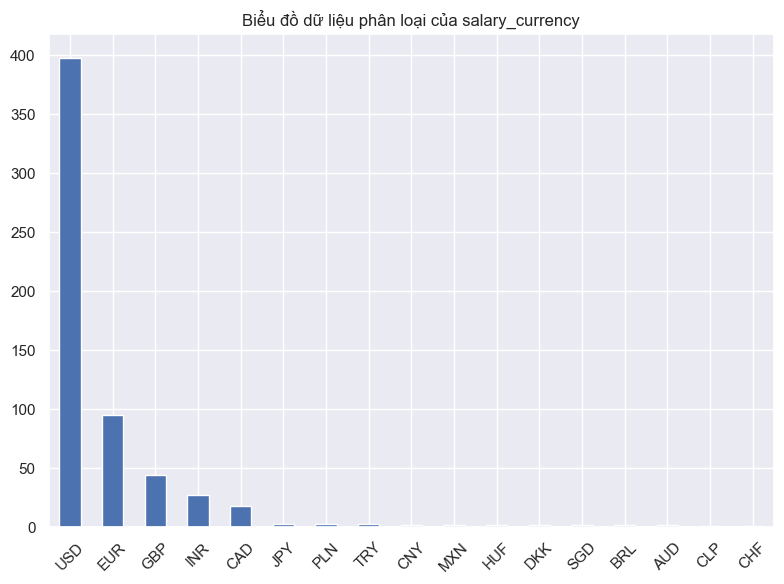


Dữ liệu cơ bản của employee_residence:
_________________________________
Có 57 biến phân loại employee_residence là:
 ['DE' 'JP' 'GB' 'HN' 'US' 'HU' 'NZ' 'FR' 'IN' 'PK' 'PL' 'PT' 'CN' 'GR'
 'AE' 'NL' 'MX' 'CA' 'AT' 'NG' 'PH' 'ES' 'DK' 'RU' 'IT' 'HR' 'BG' 'SG'
 'BR' 'IQ' 'VN' 'BE' 'UA' 'MT' 'CL' 'RO' 'IR' 'CO' 'MD' 'KE' 'SI' 'HK'
 'TR' 'RS' 'PR' 'LU' 'JE' 'CZ' 'AR' 'DZ' 'TN' 'MY' 'EE' 'AU' 'BO' 'IE'
 'CH']
Bảng phân loại và tỷ trọng của các loại biến của employee_residence
    counts percentage
US     332      54.7%
GB      44      7.25%
IN      30      4.94%
CA      29      4.78%
DE      25      4.12%
FR      18      2.97%
ES      15      2.47%
GR      13      2.14%
JP       7      1.15%
PT       6      0.99%
BR       6      0.99%
PK       6      0.99%
NL       5      0.82%
PL       4      0.66%
IT       4      0.66%
RU       4      0.66%
AE       3      0.49%
AT       3      0.49%
VN       3      0.49%
TR       3      0.49%
AU       3      0.49%
RO       2      0.33%
BE       2      

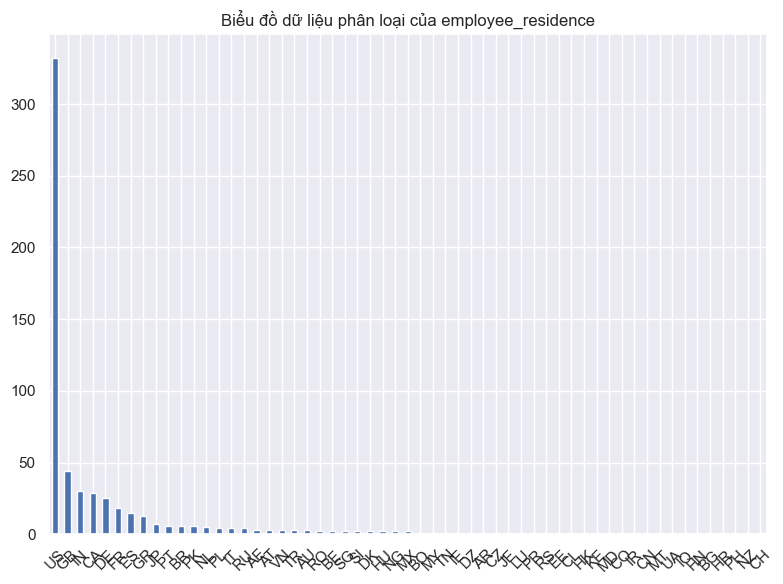


Dữ liệu cơ bản của remote_ratio:
_________________________________
Có 3 biến phân loại remote_ratio là:
 [  0  50 100]
Bảng phân loại và tỷ trọng của các loại biến của remote_ratio
     counts percentage
100     381     62.77%
0       127     20.92%
50       99     16.31%


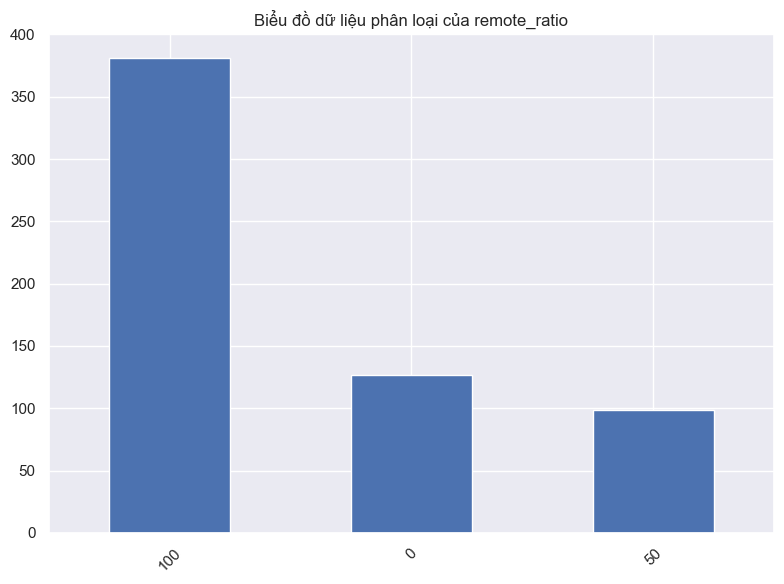


Dữ liệu cơ bản của company_location:
_________________________________
Có 50 biến phân loại company_location là:
 ['DE' 'JP' 'GB' 'HN' 'US' 'HU' 'NZ' 'FR' 'IN' 'PK' 'CN' 'GR' 'AE' 'NL'
 'MX' 'CA' 'AT' 'NG' 'ES' 'PT' 'DK' 'IT' 'HR' 'LU' 'PL' 'SG' 'RO' 'IQ'
 'BR' 'BE' 'UA' 'IL' 'RU' 'MT' 'CL' 'IR' 'CO' 'MD' 'KE' 'SI' 'CH' 'VN'
 'AS' 'TR' 'CZ' 'DZ' 'EE' 'MY' 'AU' 'IE']
Bảng phân loại và tỷ trọng của các loại biến của company_location
    counts percentage
US     355     58.48%
GB      47      7.74%
CA      30      4.94%
DE      28      4.61%
IN      24      3.95%
FR      15      2.47%
ES      14      2.31%
GR      11      1.81%
JP       6      0.99%
NL       4      0.66%
AT       4      0.66%
PT       4      0.66%
PL       4      0.66%
LU       3      0.49%
PK       3      0.49%
BR       3      0.49%
AE       3      0.49%
MX       3      0.49%
AU       3      0.49%
TR       3      0.49%
DK       3      0.49%
IT       2      0.33%
CZ       2      0.33%
SI       2      0.33%
RU       2    

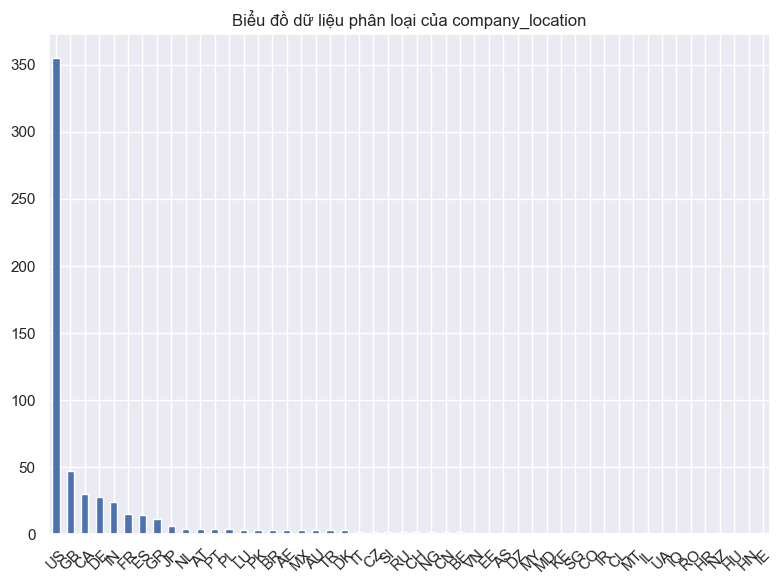


Dữ liệu cơ bản của company_size:
_________________________________
Có 3 biến phân loại company_size là:
 ['L' 'S' 'M']
Bảng phân loại và tỷ trọng của các loại biến của company_size
   counts percentage
M     326     53.71%
L     198     32.62%
S      83     13.67%


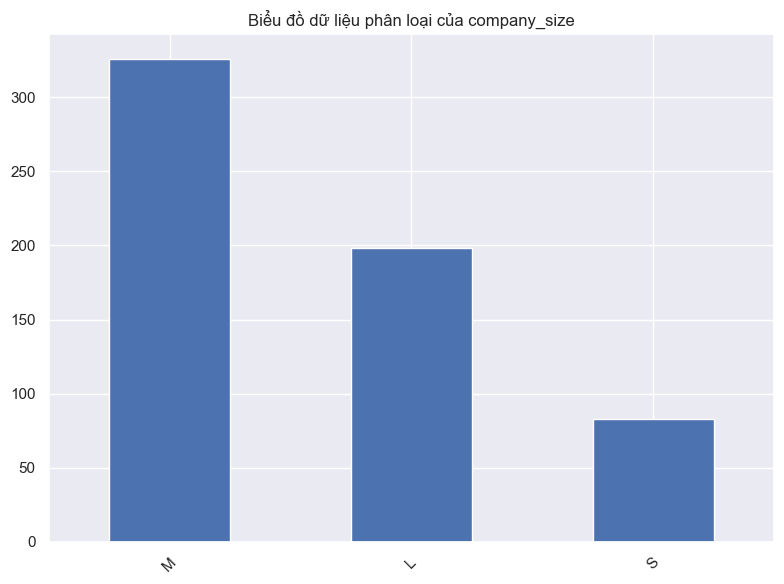

In [16]:
for col in categorical_variables:
    phan_tich_don_bien (data, col, 'cate')

#### Nhận xét:
- Các biến phân loại phân bố không đồng đều


#### Phân tích đơn biến continuous


Thống kê cơ bản salary
_________________________________
Số lượng kiểu biến trong salary là 272 	 
Max = 30400000 	Min 4000
Range = 30396000
Mean = 324000.0626029654
Median = 115000.0
Mode = [ 80000 100000]
_________________________________
Variance = 2381110820751.384
Standard deviation = 1543084.839
_________________________________
Tứ phân vị số Q1: 70000.0 
Tứ phân vị số Q3: 165000.0
IQR: 95000.0
Số lượng lower outliers: 0
Số lượng upper outliers: 44
Số lượng outlier chiếm 7.249 %
_________________________________
Phân phối lệch phải với giá trị skew = 14.052915442625148
Phân phối nhọn hơn phân phối chuẩn với kurt= 247.42603923016264
_________________________________
Visualize


C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


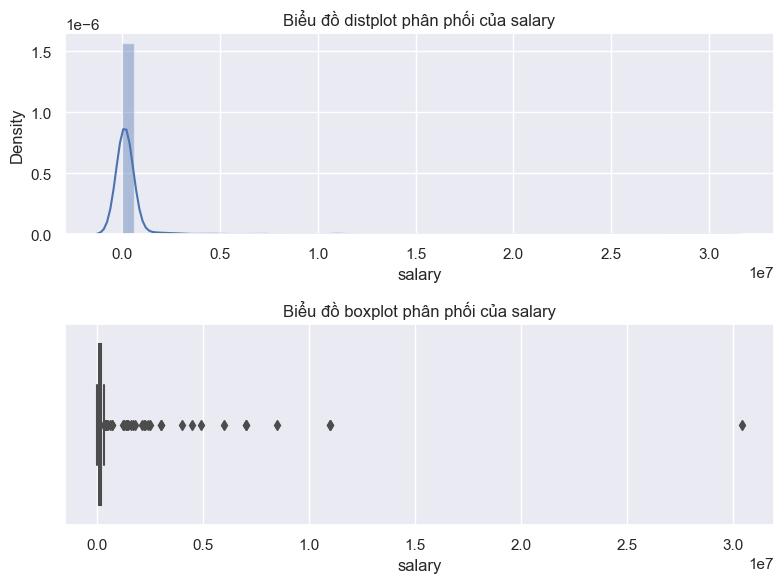


Thống kê cơ bản salary_in_usd
_________________________________
Số lượng kiểu biến trong salary_in_usd là 369 	 
Max = 600000 	Min 2859
Range = 597141
Mean = 112297.86985172982
Median = 101570.0
Mode = [100000]
_________________________________
Variance = 5026637881.194
Standard deviation = 70898.786
_________________________________
Tứ phân vị số Q1: 62726.0 
Tứ phân vị số Q3: 150000.0
IQR: 87274.0
Số lượng lower outliers: 0
Số lượng upper outliers: 10
Số lượng outlier chiếm 1.647 %
_________________________________
Phân phối lệch phải với giá trị skew = 1.667544954563863
Phân phối nhọn hơn phân phối chuẩn với kurt= 6.353794741063377
_________________________________
Visualize


C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


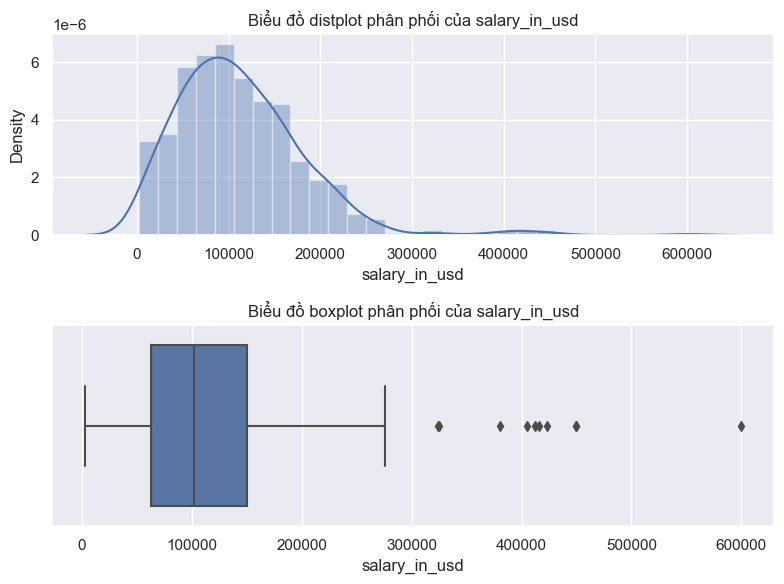

In [17]:
for col in continuous_variables:
    phan_tich_don_bien (data, col, 'cont')

#### Nhận xét:
- Các biến liên tục đều lệch phải
- Các biến liên tục xuất hiện outliers


### Phân tích đa biến

Input - Input: continuous - continuous    

In [18]:
#chỉ có 1 biến input là continuous
'''plt.figure(figsize=(10,10),tight_layout=True)
sns.heatmap(data[continuous_variables].corr(),annot=True,cmap='coolwarm')
plt.title('Biểu đồ phân tích tương quan các biến liên tục')'''

"plt.figure(figsize=(10,10),tight_layout=True)\nsns.heatmap(data[continuous_variables].corr(),annot=True,cmap='coolwarm')\nplt.title('Biểu đồ phân tích tương quan các biến liên tục')"

#### Input - Input: categorical - categorical

In [19]:
chi2_test_df=pd.DataFrame(index=categorical_variables,columns=categorical_variables)
alpha=0.05
for i in range(len(categorical_variables)):
    for j in range(i+1,len(categorical_variables)):
        table=pd.crosstab(data[categorical_variables[i]],data[categorical_variables[j]])
        stat,p,dof,expected=chi2_contingency(table)
        if p<alpha:
            chi2_test_df.loc[categorical_variables[i],categorical_variables[j]]='Dependent'
        else:
            chi2_test_df.loc[categorical_variables[i],categorical_variables[j]]='Independent'
chi2_test_df

,work_year,experience_level,employment_type,job_title,salary_currency,employee_residence,remote_ratio,company_location,company_size
work_year,NaN,Dependent,Independent,Dependent,Dependent,Dependent,Dependent,Dependent,Dependent
experience_level,NaN,NaN,Dependent,Dependent,Dependent,Dependent,Dependent,Dependent,Dependent
employment_type,NaN,NaN,NaN,Dependent,Independent,Dependent,Dependent,Dependent,Independent
job_title,NaN,NaN,NaN,NaN,Dependent,Dependent,Dependent,Dependent,Dependent
salary_currency,NaN,NaN,NaN,NaN,NaN,Dependent,Dependent,Dependent,Dependent
employee_residence,NaN,NaN,NaN,NaN,NaN,NaN,Dependent,Dependent,Dependent
remote_ratio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dependent,Dependent
company_location,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dependent
company_size,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Input - Input: categorical - continuous
#### Input - Output: Categorical - continuous


Phân tích giữa biến liên tục salary và biến phân loại
Theo kết quả từ Anova table với alpha = 0.05, các thuộc tính Categorical có mối quan hệ phụ thuộc với thuộc tính salary
['work_year', 'salary_currency', 'employee_residence', 'remote_ratio', 'company_location', 'company_size']


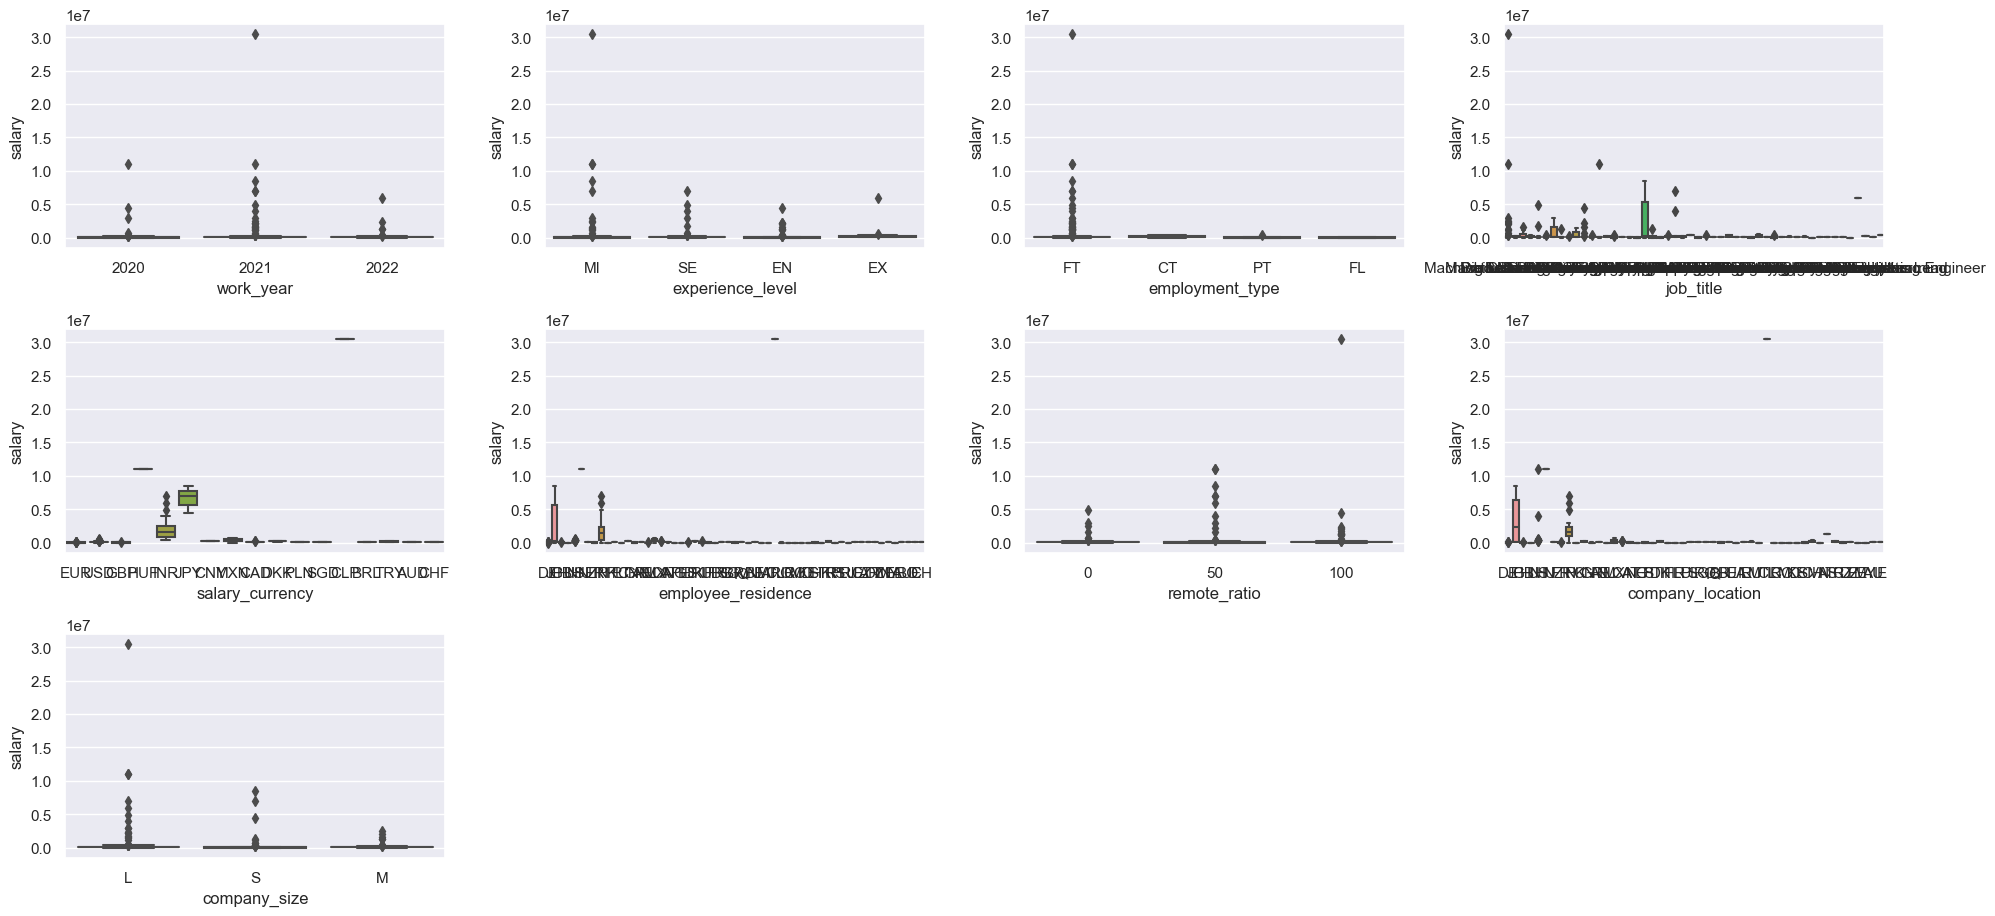


Phân tích giữa biến liên tục salary_in_usd và biến phân loại
Theo kết quả từ Anova table với alpha = 0.05, các thuộc tính Categorical có mối quan hệ phụ thuộc với thuộc tính salary_in_usd
['work_year', 'experience_level', 'employment_type', 'job_title', 'salary_currency', 'employee_residence', 'remote_ratio', 'company_location', 'company_size']


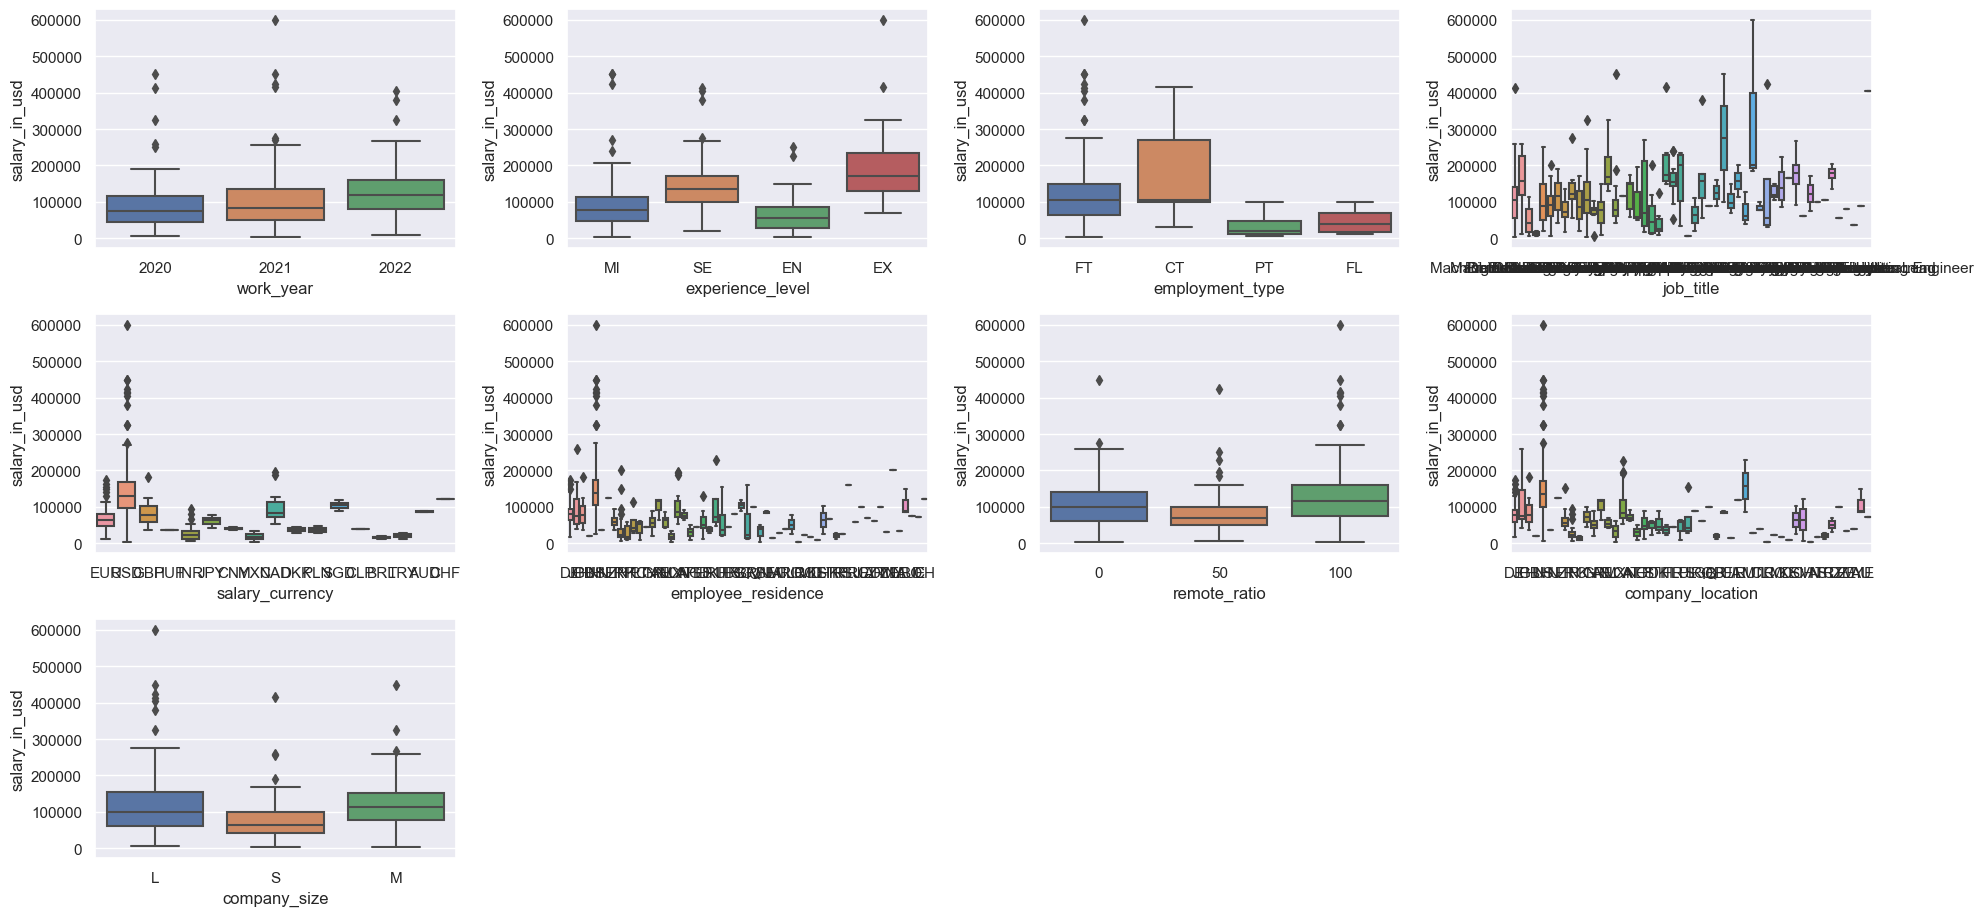

In [20]:
for j in continuous_variables:
    depend=[]
    print(f'\nPhân tích giữa biến liên tục {j} và biến phân loại')
    plt.figure(figsize=(20,18))
    for i in range(1,len(categorical_variables)+1):
        df_melt=data[[categorical_variables[i-1],j]]
        plt.subplot(6,4,i)
        sns.boxplot(data=df_melt,x=categorical_variables[i-1],y=j)
        alpha=0.05
        df_temp=data[[j,categorical_variables[i-1]]]
        df_temp.columns=['cont_data','cate_data']
        bt='cont_data~C(cate_data)'
        model=ols(bt,data=df_temp).fit()
        anova_table=sm.stats.anova_lm(model,typ=2)
        if anova_table.values[0,3]<alpha:
            depend.append(categorical_variables[i-1])
        i=i+1
    print('Theo kết quả từ Anova table với alpha = 0.05, các thuộc tính Categorical có mối quan hệ phụ thuộc với thuộc tính',j)
    print(depend)
    plt.tight_layout()
    plt.show()

Input - Output: continuous - continuous

Text(0.5, 1.0, 'Biểu đồ phân tích tương quan các biến liên tục')

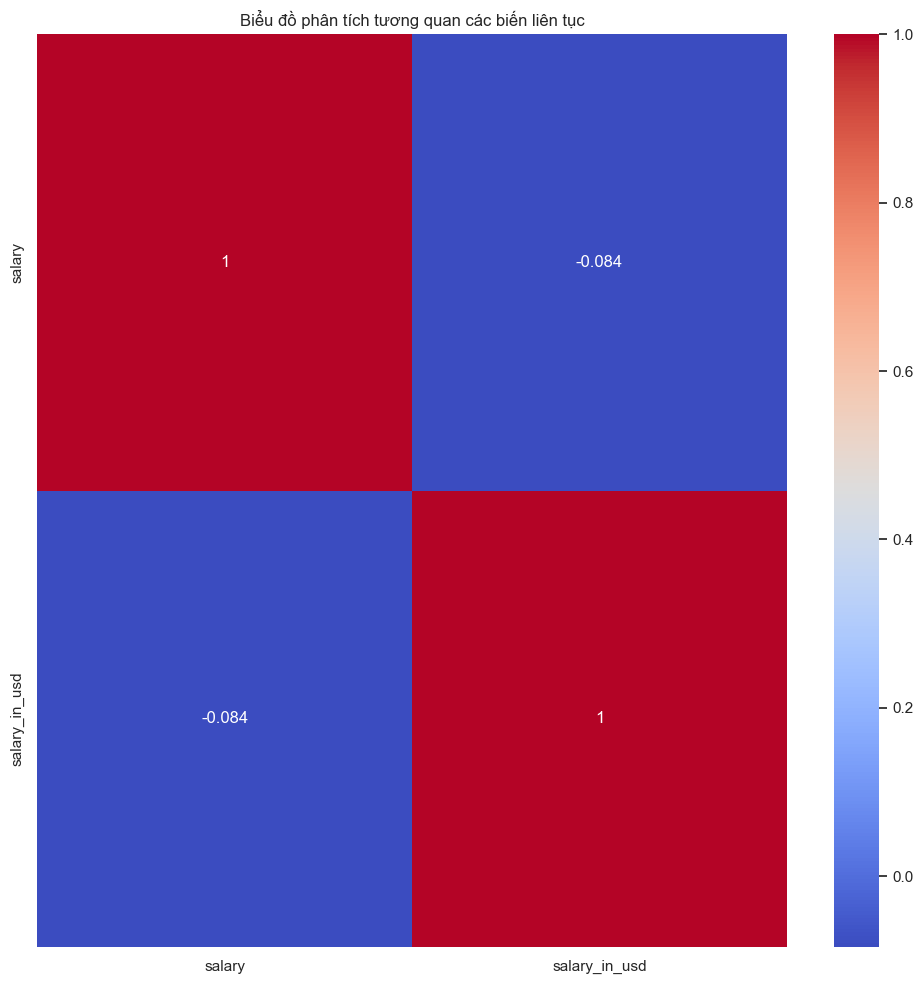

In [21]:
plt.figure(figsize=(10,10),tight_layout=True)
sns.heatmap(data[continuous_variables].corr(),annot=True,cmap='coolwarm')
plt.title('Biểu đồ phân tích tương quan các biến liên tục')

==> 2 biến này tương quan yếu

In [22]:
def number_of_outliers (cont_var,df,df_outliers):
    upper_outliers=len(df[cont_var][df[cont_var]>(np.quantile(df[cont_var],0.75)+1.5*scipy.stats.iqr(df[cont_var]))])
    lower_outliers=len(df[cont_var][df[cont_var]<(np.quantile(df[cont_var],0.25)-1.5*scipy.stats.iqr(df[cont_var]))])
    outlier_per=(upper_outliers+lower_outliers)/len(df[cont_var])
    df_outliers.loc[cont_var,'upper_outliers']=upper_outliers
    df_outliers.loc[cont_var,'lower_outliers']=lower_outliers
    df_outliers.loc[cont_var,'outlier_per']=round(outlier_per,4)*100

In [23]:
df_outliers=pd.DataFrame(index=continuous_variables,columns=['upper_outliers','lower_outliers','outlier_per'])
for var in continuous_variables:
    number_of_outliers (var,data,df_outliers)
df_outliers

,upper_outliers,lower_outliers,outlier_per
salary,44,0,7.25
salary_in_usd,10,0,1.65


In [24]:
fc_outliers=data[data['salary']>np.quantile(data['salary'],0.75)+1.5*scipy.stats.iqr(data['salary'])]
fc_outliers['salary_in_usd'].value_counts()

6072      2
18442     2
450000    2
35735     1
28399     1
5882      1
33808     1
416000    1
16228     1
21637     1
18053     1
600000    1
66265     1
16904     1
24342     1
94665     1
79039     1
31615     1
324000    1
380000    1
54094     1
5679      1
22611     1
29751     1
41689     1
5707      1
325000    1
33511     1
412000    1
5409      1
19609     1
36259     1
40481     1
30428     1
9466      1
40570     1
63711     1
77364     1
423000    1
40038     1
405000    1
Name: salary_in_usd, dtype: int64

In [25]:
fc_q3=np.quantile(data['salary'],0.75)+1.5*scipy.stats.iqr(data['salary'])

In [26]:
data_clean=data.copy()
median=float(data_clean['salary'].median())
data_clean['salary']=np.where(data_clean['salary']>fc_q3,median,data_clean['salary'])

#### Encoding

In [27]:
from feature_engine.encoding import OneHotEncoder

In [28]:
for col in categorical_variables:
    if data_clean[col].dtypes !='object':
        data_clean[col]=data_clean[col].astype('object')

In [29]:
ohe=OneHotEncoder(variables=categorical_variables,drop_last=True)

In [30]:
data_clean=ohe.fit_transform(data_clean)

C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\feature_engine\encoding\one_hot.py:252: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[str(feature) + "_" + str(category)] = np.where(
C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\feature_engine\encoding\one_hot.py:252: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[str(feature) + "_" + str(category)] = np.where(
C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\feature_engine\encoding\one_hot.py:252: Perfor

C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\feature_engine\encoding\one_hot.py:252: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[str(feature) + "_" + str(category)] = np.where(
C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\feature_engine\encoding\one_hot.py:252: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[str(feature) + "_" + str(category)] = np.where(
C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\feature_engine\encoding\one_hot.py:252: Perfor

C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\feature_engine\encoding\one_hot.py:252: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[str(feature) + "_" + str(category)] = np.where(
C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\feature_engine\encoding\one_hot.py:252: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[str(feature) + "_" + str(category)] = np.where(
C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\feature_engine\encoding\one_hot.py:252: Perfor

C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\feature_engine\encoding\one_hot.py:252: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[str(feature) + "_" + str(category)] = np.where(
C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\feature_engine\encoding\one_hot.py:252: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[str(feature) + "_" + str(category)] = np.where(
C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\feature_engine\encoding\one_hot.py:252: Perfor

#### Split

In [31]:
data_final=data_clean.copy()

In [32]:
X=data_final.drop('salary_in_usd',axis=1)
y=data_final['salary_in_usd']

In [33]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [34]:
y_train.value_counts()

100000    12
150000    10
200000     9
80000      7
120000     7
          ..
55000      1
157000     1
28369      1
242000     1
36259      1
Name: salary_in_usd, Length: 311, dtype: int64

In [35]:
X_train

,salary,work_year_2020,work_year_2021,experience_level_MI,experience_level_SE,experience_level_EN,employment_type_FT,employment_type_CT,employment_type_PT,job_title_Data Scientist,...,company_location_VN,company_location_AS,company_location_TR,company_location_CZ,company_location_DZ,company_location_EE,company_location_MY,company_location_AU,company_size_L,company_size_S
9,125000.0,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
227,75000.0,0,1,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
591,144854.0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
516,152500.0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
132,38400.0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,37000.0,1,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
106,235000.0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
270,72500.0,0,1,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
435,70000.0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### feature selection

C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:68

C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:68

C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:68

C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:68

C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:68

<AxesSubplot:>

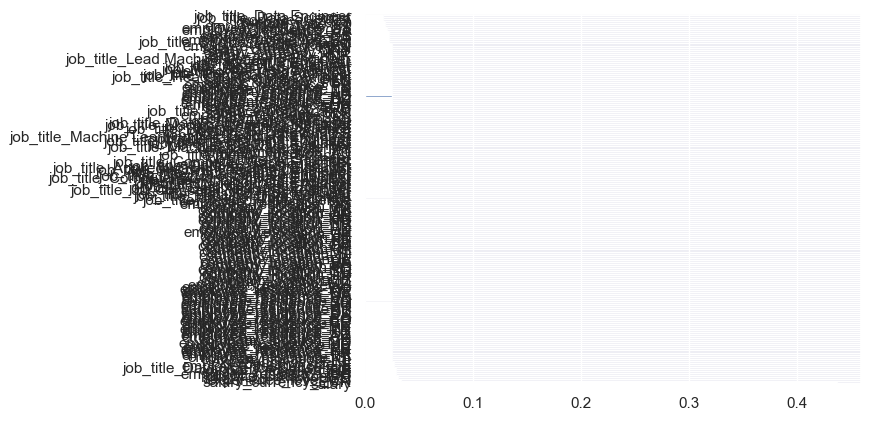

In [36]:
rf=RandomForestClassifier(n_estimators=100,random_state=42,n_jobs=6)
sel=SelectBySingleFeaturePerformance(
    variables=None,
    estimator=rf,
    scoring="accuracy",
    cv=3,
    threshold=0.5)
sel.fit(X_train,y_train)
important_features=pd.Series(sel.feature_performance_,index=X.columns).sort_values(ascending=False)
important_features.plot(kind='barh')

In [37]:
pd.set_option('display.max_rows', None)
important_features

salary                                                0.437109
salary_currency_EUR                                   0.032986
experience_level_EN                                   0.030941
salary_currency_USD                                   0.030928
job_title_Data Analyst                                0.028870
employee_residence_GB                                 0.028858
salary_currency_GBP                                   0.028858
company_location_GB                                   0.028858
job_title_Data Science Consultant                     0.026813
employee_residence_DE                                 0.026813
company_size_L                                        0.026813
experience_level_MI                                   0.024755
company_location_KE                                   0.024742
employee_residence_SI                                 0.024742
employee_residence_HK                                 0.024742
employee_residence_TR                                 0

Chọn tất cả các biến

#### Scaling

In [38]:
scaler=SklearnTransformerWrapper(transformer=MinMaxScaler(),variables=data_final.drop('salary_in_usd',axis=1).columns.values.tolist())

In [39]:
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [40]:
X_train.head()

,salary,work_year_2020,work_year_2021,experience_level_MI,experience_level_SE,experience_level_EN,employment_type_FT,employment_type_CT,employment_type_PT,job_title_Data Scientist,...,company_location_VN,company_location_AS,company_location_TR,company_location_CZ,company_location_DZ,company_location_EE,company_location_MY,company_location_AU,company_size_L,company_size_S
9,0.408784,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
227,0.239865,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
591,0.475858,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
516,0.501689,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
132,0.116216,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Model selection

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold
from datetime import datetime
from datetime import timedelta
from sklearn.model_selection import KFold

In [42]:
models=[
    LogisticRegression(multi_class='auto',max_iter=1000),
    GaussianNB(),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=50),
    RandomForestClassifier(n_estimators=100),
    SVC(kernel='rbf'),
    SVC(kernel='linear'),
    KNeighborsClassifier(n_neighbors=6),
    KNeighborsClassifier(n_neighbors=12)
]

In [43]:
def get_model_name(model):
    model_name=model.__class__.__name__
    if model_name=='RandomForestClassifier':
        model_name+='_'+str(model.n_estimators)
    elif model_name=='KNeighborsClassifier':
        model_name+='_'+str(model.n_neighbors)
    elif model_name=='SVC':
        model_name+='_'+str(model.kernel)
    return model_name

In [44]:
kf=KFold(n_splits=10)
cv_df=pd.DataFrame(columns=['model','mean_score','std_score','accuracy_train','accuracy_test','time'])
for model in models:
    model_name=get_model_name(model)
    start_time=datetime.now()
    cv_score=cross_val_score(model,X_train,y_train,cv=kf,n_jobs=-1)
    end_time=datetime.now()
    time_taken=end_time-start_time
    model.fit(X_train,y_train)
    accuracy_train=round(model.score(X_train,y_train)*100,3)
    accuracy_test=round(model.score(X_test,y_test)*100,3)
    cv_df=pd.concat([cv_df,pd.DataFrame.from_records([
        {
            'model':model_name,
            'mean_score':cv_score.mean(),
            'std_score':cv_score.std(),
            'accuracy_train':accuracy_train,
            'accuracy_test':accuracy_test,
            'time':str(time_taken),
            
        }
    ])],ignore_index=True)

In [45]:
metrics=cv_df.sort_values(by=['mean_score'],ascending=False)
metrics

,model,mean_score,std_score,accuracy_train,accuracy_test,time
2,DecisionTreeClassifier,0.350468,0.081336,100.0,32.787,0:00:00.109180
1,GaussianNB,0.181335,0.06055,100.0,17.213,0:00:00.178078
4,RandomForestClassifier_100,0.125638,0.030748,100.0,13.934,0:00:01.733011
3,RandomForestClassifier_50,0.123724,0.037148,100.0,14.754,0:00:00.836895
7,KNeighborsClassifier_6,0.057653,0.030244,26.804,5.738,0:00:00.235451
8,KNeighborsClassifier_12,0.041114,0.028955,17.938,7.377,0:00:00.048531
0,LogisticRegression,0.020663,0.016139,49.691,4.918,0:00:04.683033
6,SVC_linear,0.018495,0.021402,64.124,5.738,0:00:00.940149
5,SVC_rbf,0.016539,0.012459,16.495,2.459,0:00:01.049937


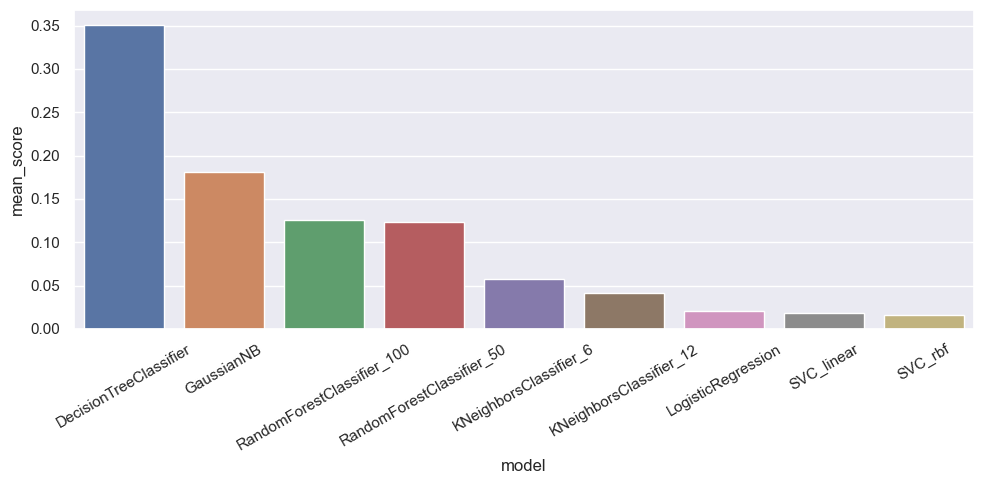

In [46]:
plt.figure(figsize=(10,5),tight_layout=True)
sns.barplot(x='model',y='mean_score',data=metrics)
plt.xticks(rotation=30)
plt.show()

In [47]:
param_grid={
    'n_estimators':[30,50,80,100,200],
    'max_depth':[3,4,5,6],
    'criterion':['entropy','gini'],
    'bootstrap':[True,False]
}
clf_grid=GridSearchCV(RandomForestClassifier(),param_grid,cv=kf,n_jobs=-1)
search_clf=clf_grid.fit(X_train,y_train)
best_clf=search_clf.best_estimator_
cross_clf=cross_val_score(best_clf,X_test,y_test,scoring='accuracy',cv=kf,n_jobs=-1)

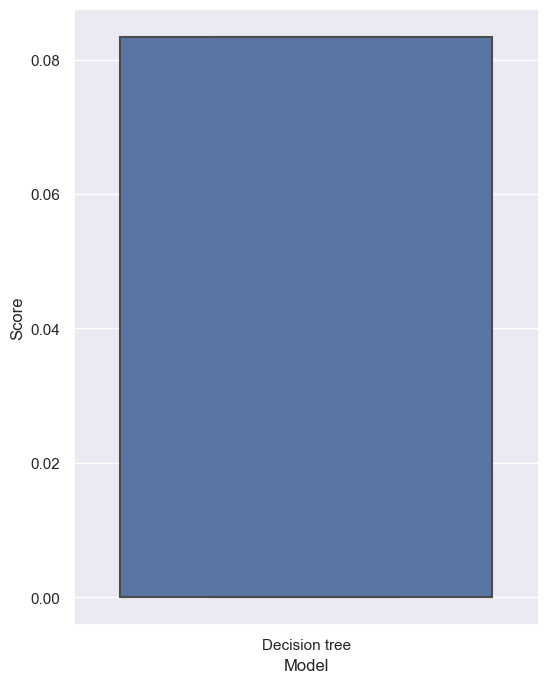

Best parameters:{'bootstrap': False, 'criterion': 'gini', 'max_depth': 6, 'n_estimators': 200}
Best score:0.07827380952380952


In [48]:
clf_accu=pd.DataFrame(data={'Score':cross_clf,'Metric':'Accuracy','Model':'Decision tree'})
plt.figure(figsize=(6,8))
sns.boxplot(data=clf_accu,x="Model",y="Score")
plt.show()
print("Best parameters:{}".format(clf_grid.best_params_))
print("Best score:{}".format(clf_grid.best_score_))

#### Model evaluation

In [49]:
from sklearn.tree import DecisionTreeRegressor
best_model = DecisionTreeRegressor()
parameters_dt = best_model.get_params()

In [50]:
parameters_dt['criterion']='gini'
parameters_dt['max_depth']=6

In [51]:
best_model.fit(X_train,y_train)

DecisionTreeRegressor()

In [52]:
y_pred=best_model.predict(X_test)

In [53]:
train_acc=round(best_model.score(X_train,y_train)*100,3)
test_acc=round(best_model.score(X_test,y_test)*100,3)
print("Train accuracy:{}".format(train_acc),"Test accuracy:{}".format(test_acc))

Train accuracy:100.0 Test accuracy:50.866


In [54]:
from sklearn import metrics
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))

Mean Squared Error: 1883106330.909836


In [55]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.5086569232937417

In [56]:
y_test=np.array(y_test)

In [57]:
df = pd.DataFrame({'Actual': pd.DataFrame(y_test)[0].values,
'Prediction': pd.DataFrame(y_pred)[0].values})
df.head(10)

,Actual,Prediction
0,140250,140000.0
1,135000,135000.0
2,100000,100000.0
3,270000,276000.0
4,26005,25000.0
5,153000,152500.0
6,51321,49461.0
7,49646,47899.0
8,76940,76940.0
9,59102,54742.0


### Tuy MSE cao nhưng mô hình predict được sấp xỉ mức actual